## Building statistical solar forecasts from measurement data
#### Dragos Boros
##### Alpiq

In [135]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

from IPython.core.display import HTML
plt.style.use('seaborn')
#print(np.__version__,pd.__version__)  # check versions

In [117]:
df = pd.read_csv("solar.csv", sep =";", index_col=0, parse_dates=True, dayfirst=True)
df['production'] = df['production'].str.replace(' ', '').astype('float')
#d = df[['realized']]
#d1 =d['2016-1':'2016-8']

In [119]:
def display(*args,axis=0):
    """helper function to display dfs sided by side or on top of each other"""
    return HTML((''.join(a._repr_html_() + '<br style="clear: both;">' for a in args )
                if axis == 0 else 
                 ''.join('<div style="float: left; padding: 20px">'+a._repr_html_()+'</div>' for a in args)))

In [120]:
def compare(df1,df2):
    """helper function to compare two dfs"""
    return pd.concat([df1,df2],axis=1,keys=['original', 'transformed'])

In [144]:
def prev(df):
    """ tomorrow's forecasted values are today's realized values"""
    return df[:24].append(df.shift(1,'D')[:-24])
display (compare(df,prev(df))[12:16],compare(df,prev(df))[36:40],axis =1)

,original,transformed
,production,production
value_time,,
2016-01-01 12:00:00,612.0,612.0
2016-01-01 13:00:00,83.0,83.0
2016-01-01 14:00:00,57.0,57.0
2016-01-01 15:00:00,99.0,99.0
,original,transformed
,production,production
value_time,,
2016-01-02 12:00:00,80.0,612.0


In [122]:
def prev2(df):
    """ tomorrow's forecasted values are the average of (today's and yesterday's) realized values"""
    x = prev(df)
    return (x + prev(x) ) / 2

In [123]:
def prev3(df):
    """ tomorrow's forecasted values are the average of (today's and previous 2 days) realized values"""
    x = prev(df)
    y = prev(x)
    return (x + y + prev(y) ) / 3

In [124]:
def month_hour_avg(df):
    """ df transformed to monthly hourly averages"""
    b = df.copy()
    b['month'] = b.index.month
    b['hour']  = b.index.hour
    out = b.merge( b.groupby(['month','hour']).mean(),
                   how='left', left_on=['month', 'hour'], 
                   right_index=True, suffixes=('ignore',''))[df.columns]
    return out

In [125]:
def detect_suspicious_hours(d,threshold = 0.05, avg_threshold = 200):
    """detects hours with suspicious low production 
       such hours satisfy the folowing two conditions:
           - hourly value is smaller than the product threshold * monthly average for that hour
           - monthly average for an hour is higher than an absolute threshold
    """
    out = pd.concat([d,month_hour_avg(d)],axis=1,keys=['original', 'avg_value'])
    out.columns = out.columns.droplevel(1)
    return out.query('original < avg_value * @threshold and avg_value > @avg_threshold' )
detect_suspicious_hours(df)[:3]

,original,avg_value
value_time,,
2016-01-02 15:00:00,9.0,377.774194
2016-01-18 15:00:00,12.0,377.774194
2016-02-03 08:00:00,12.0,274.137931


In [126]:
def clear_suspicious_hours(df):
    out = df.copy()
    out.loc[detect_suspicious_hours(df).index, df.columns] = np.nan
    return out
#clear_suspicious_hours(df)[:3]

In [127]:
def replace_suspicious_values(df, compare=False):
    v = clear_suspicious_hours(df)
    x = v.copy()
    x[x.isnull()] = month_hour_avg(v)
    out = pd.concat([df,v,x],axis=1,keys=['original_production','valid_production', 'filled_production',])
    out.columns = out.columns.droplevel(1)
    return out if compare else out[['filled_production']]
#replace_suspicious_values(df, compare=True).to_clipboard()       

In [142]:
# compare raw production and statistical forecasts
def compare_forecasts(df):
    c = replace_suspicious_values(df)
    out = pd.concat([df,c,prev(df),prev2(df),prev3(df),
                     month_hour_avg(df),month_hour_avg(c)], 
                    keys=['original_production','corrected_production','prevday','prev2days','prev3days',
                          'monthavg_nocorrection','monthavg_withcorrection'], axis=1)
    out.columns = out.columns.droplevel(1)
    return out
res = compare_forecasts(df)
res.to_clipboard()

In [130]:
#z = pd.DataFrame(pd.date_range(start='2016-01-01',end='2016-09-01',freq='H')[:-1], columns=['VALUE_TIME'])

#d.groupby(d.index.month).sum() / d.sum()
#d.groupby([d.index.month, d.index.hour]).mean().unstack()

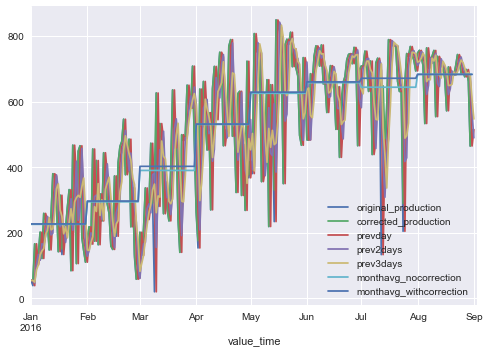

In [136]:
res.resample('D').mean().plot();

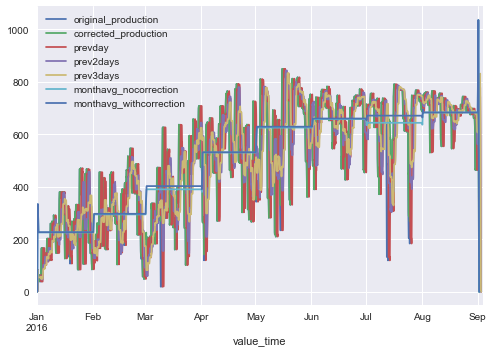

In [141]:
res.rolling('24h').mean().plot();

In [194]:
b = df.copy()
c = b.groupby([pd.to_datetime(b.index.date),b.index.hour]).mean().unstack()   #  hours by date
d = c.sum(axis=1)  # total by date
daily_shape = c.divide(d, axis=0)
small = daily_shape[:30]

In [195]:
small.sample(n=3, replace=True, random_state =3)

production                                                         \
value_time         0    1    2    3    4    5    6    7         8         9    
2016-01-11        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.007328  0.122322   
2016-01-25        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.034067  0.105245   
2016-01-26        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.003524  0.037588   

           ...                                                               \
value_time ...         14        15        16        17   18   19   20   21   
2016-01-11 ...   0.010147  0.006483  0.000564  0.000000  0.0  0.0  0.0  0.0   
2016-01-25 ...   0.089002  0.088550  0.037451  0.000338  0.0  0.0  0.0  0.0   
2016-01-26 ...   0.128818  0.098277  0.021926  0.000000  0.0  0.0  0.0  0.0   

                      
value_time   22   23  
2016-01-11  0.0  0.0  
2016-01-25  0.0  0.0  
2016-01-26  0.0  0.0  

[3 rows x 24 columns]

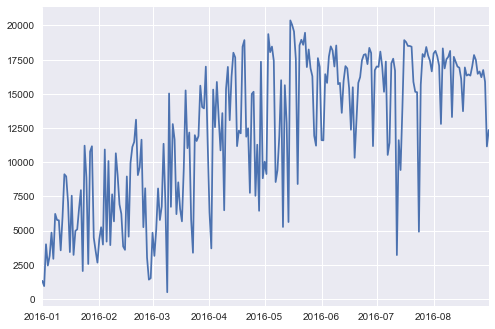

In [186]:
d.plot()

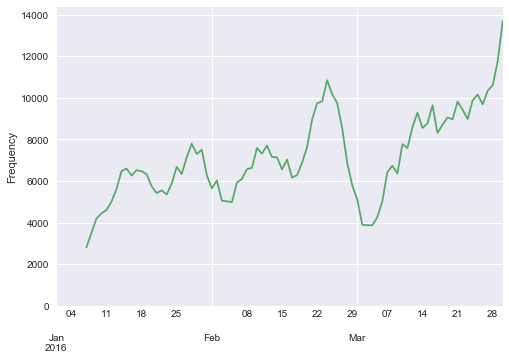

In [269]:
d[:30].plot.hist(bins=15)
d[:90].rolling(7).mean().plot()

In [196]:
small.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
#find best distribution
#https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1

In [208]:
pivoted = df.pivot_table('production', index= df.index.time, columns=df.index.date)
pivoted.iloc[:5,:3]

,2016-01-01,2016-01-02,2016-01-03
00:00:00,0.0,0.0,0.0
01:00:00,0.0,0.0,0.0
02:00:00,0.0,0.0,0.0
03:00:00,0.0,0.0,0.0
04:00:00,0.0,0.0,0.0


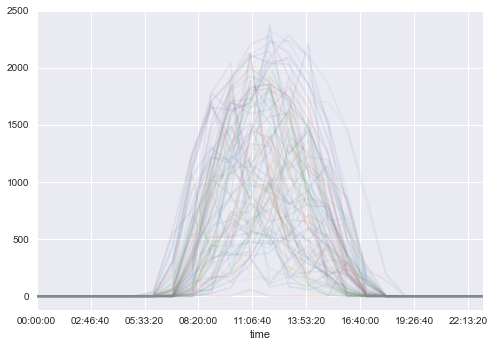

In [261]:
pivoted.iloc[:,:90].plot(legend=False,alpha=0.1)

In [258]:
pivoted2 = df.pivot_table('production', index= df.index.strftime('%H'), columns=df.index.strftime('%m_%B'))
pivoted2.head()

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [254]:
pivoted2.index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

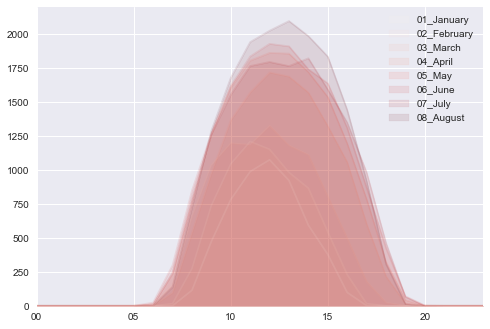

In [259]:
pivoted2.plot.area(stacked=False, alpha=0.1, colormap='Reds')

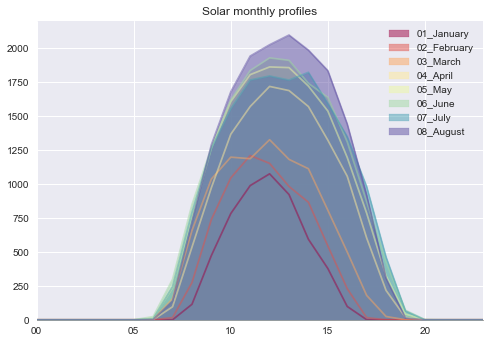

In [260]:
pivoted2.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral', title='Solar monthly profiles')

In [263]:
#https://www.youtube.com/watch?v=J45NJ0pJXWQ&list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ&t=156

In [262]:
#check teh normals

In [264]:
pivoted3 = df.pivot_table('production', index= df.index.strftime('%H'), columns=df.index.strftime('%m_%B'), aggfunc=np.std)

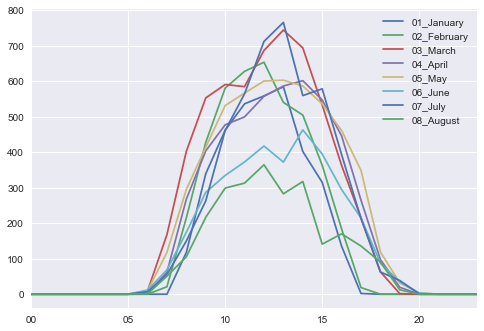

In [265]:
pivoted3.plot()

In [ ]:
#https://thegrid.rexel.com/en-us/energy_efficiency/w/solar_renewable_and_energy_efficiency/70/nasa-atmospheric-science-data-center-solar-power-potential-according-to-location
#https://thegrid.rexel.com/en-us/energy_efficiency/w/solar_renewable_and_energy_efficiency/72/how-to-calculate-the-output-of-a-solar-photovoltaic-system---a-detailed-guide
#https://eosweb.larc.nasa.gov/cgi-bin/sse/grid.cgi?&num=190131&lat=40.92&hgt=100&submit=Submit&veg=17&sitelev=&email=skip@larc.nasa.gov&p=grid_id&p=ret_tlt0&p=ret_esh0&p=ret_psh0&step=2&lon=9.49